# Предсказание кредитного дефолта

**Цель проекта** — разработать модель машинного обучения для предсказания попадения клиента в статус дефолт.  
**Описание данных:**  
Исходный датасет взят из Kaggle (https://www.kaggle.com/datasets/nikhil1e9/loan-default/data) и содержит 255 347 наблюдений и 18 признаков. Целевая переменная — бинарный флаг `Default` (1 — дефолт, 0 — не дефолт).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps
from typing import Union, Tuple
import warnings
warnings.filterwarnings('ignore')

## Посмотрим на данные

In [2]:
df = pd.read_csv('./loan_default.csv',sep=',', index_col=0)
df.head()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
LoanID,,,,,,,,,,,,,,,,,
I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 255347 entries, I38PQUQS96 to ZTH91CGL0B
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Age             255347 non-null  int64  
 1   Income          255347 non-null  int64  
 2   LoanAmount      255347 non-null  int64  
 3   CreditScore     255347 non-null  int64  
 4   MonthsEmployed  255347 non-null  int64  
 5   NumCreditLines  255347 non-null  int64  
 6   InterestRate    255347 non-null  float64
 7   LoanTerm        255347 non-null  int64  
 8   DTIRatio        255347 non-null  float64
 9   Education       255347 non-null  object 
 10  EmploymentType  255347 non-null  object 
 11  MaritalStatus   255347 non-null  object 
 12  HasMortgage     255347 non-null  object 
 13  HasDependents   255347 non-null  object 
 14  LoanPurpose     255347 non-null  object 
 15  HasCoSigner     255347 non-null  object 
 16  Default         255347 non-null  int64  
dtypes:

In [4]:
df.isna().sum()

Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64

In [5]:
df['Default'].mean()

0.11612824901017048

In [6]:
features = [col for col in df.columns if col != 'Default']

**Рассмотрим числовые и категориальные переменные.**

In [7]:
categorical_features = [
    col for col in features
    if df[col].nunique(dropna=True) <= 15
]
print('Количество категориальных фичей:', len(categorical_features))

for col in categorical_features:
    print(col, df[col].nunique(dropna=True))

Количество категориальных фичей: 9
NumCreditLines 4
LoanTerm 5
Education 4
EmploymentType 4
MaritalStatus 3
HasMortgage 2
HasDependents 2
LoanPurpose 5
HasCoSigner 2


In [8]:
numeric_features = [col for col in features if col not in categorical_features]

## Отберем топ фичи по IV

Напишем функцию для рассчета IV (Information Value) признака:

In [9]:
def calc_iv(
        values : np.ndarray,
        target : np.ndarray,
        n_buckets : int
    ) -> float:
    """Считает для признака IV"""

    # удаляем nan
    mask = ~np.isnan(values)
    values_clean = values[mask]
    target_clean = target[mask]
    
    # делим на бакеты
    x = pd.Series(values_clean).reset_index(drop=True)
    buckets = x.rank(method="dense", pct=True) * n_buckets
    buckets = np.ceil(buckets) - 1
    buckets = np.array(buckets, dtype=np.int16)

    # считаем IV
    df_stats = pd.DataFrame({"target": target_clean, "bucket": buckets, "values": values_clean})
    stats = df_stats.groupby("bucket")["target"].agg(B_i="sum", N_i="count")
    stats["G_i"] = stats["N_i"] - stats["B_i"]
    B = stats["B_i"].sum()
    G = stats["G_i"].sum()
    
    # делаем защиту от деления на 0
    if B == 0 or G == 0:
        return 0.0
    eps = 1e-6
    stats["B_dist"] = np.clip(stats["B_i"] / B, eps, None)
    stats["G_dist"] = np.clip(stats["G_i"] / G, eps, None)
    
    stats["woe_i"] = np.log(stats["B_dist"] / stats["G_dist"])
    stats["iv_i"] = (stats["B_dist"] - stats["G_dist"]) * stats["woe_i"]

    
    IV = stats["iv_i"].sum()

    return IV

Сравнивать IV у категориальных и числовых признаков некорректно.  
Сначала отдельно отсеем числовые признаки с `IV < 0.005`:

In [10]:
print(f'Числовых признаков всего: {len(numeric_features)}')
for col in numeric_features:
    if calc_iv(df[col], df['Default'], n_buckets=20) < 0.005:
        print(f'{col}: IV = {calc_iv(df[col], df['Default'], n_buckets=20)}')
        numeric_features.remove(col)
        
print(f'Числовых признаков с IV >= 0.005: {len(numeric_features)}')

Числовых признаков всего: 7
DTIRatio: IV = 0.004487463522971173
Числовых признаков с IV >= 0.005: 6


Для того, чтобы рассчитать IV категориальных признаков, закодируем их **target encoding'ом.**

In [11]:
encoded_cat_features = []

for col in categorical_features:
    mean_target = df.groupby(col)['Default'].mean()
    new_col_name = f"{col}_enc"
    df[new_col_name] = df[col].map(mean_target).astype(float)
    # заполняем пропуски в новых колонках средним
    overall_mean = df['Default'].mean()
    df[new_col_name] = df[new_col_name].fillna(overall_mean)
    encoded_cat_features.append(new_col_name)

Теперь рассчитаем для них IV.

In [12]:
for col in encoded_cat_features:
    print(col, round(calc_iv(df[col], df['Default'], n_buckets=df[col].nunique(dropna=True)), 6))

NumCreditLines_enc 0.007902
LoanTerm_enc 2e-05
Education_enc 0.008127
EmploymentType_enc 0.020633
MaritalStatus_enc 0.007784
HasMortgage_enc 0.005096
HasDependents_enc 0.011747
LoanPurpose_enc 0.005057
HasCoSigner_enc 0.014952


Отсеем категориальные фичи по порогу IV = 0.001.

In [13]:
print(f'Категориальных признаков всего: {len(encoded_cat_features)}')
for col in encoded_cat_features:
    if calc_iv(df[col], df['Default'], n_buckets=df[col].nunique(dropna=True)) < 0.001:
        print(f'{col}: IV = {calc_iv(df[col], df['Default'], n_buckets=df[col].nunique(dropna=True))}')
        encoded_cat_features.remove(col)
        
print(f'Категориальных признаков с IV >= 0.001: {len(encoded_cat_features)}')

Категориальных признаков всего: 9
LoanTerm_enc: IV = 1.981396682743952e-05
Категориальных признаков с IV >= 0.001: 8


Признак `LoanTerm` не информативный. Его включать в модель не будем.

In [14]:
categorical_features = [f[:-4] for f in encoded_cat_features]

In [15]:
columns_to_keep = categorical_features + numeric_features + ['Default']
df = df[columns_to_keep]

Отбор признаков по IV окончен.

Закодируем категориальные фичи **one-hot encoding'ом**. Чтобы избежать мультиколлинеарности, будем удалять первую категорию во всех фичах (drop_first=True).

In [16]:
df = pd.get_dummies(df, columns=categorical_features, drop_first=True, dtype=int)

Разобьем датасет на трейн и тест (80/20).

In [17]:
from sklearn.model_selection import train_test_split
features = [col for col in df.columns if col not in ['Default', ]]
X_train, X_test, y_train, y_test = train_test_split(df[features], df['Default'], test_size=0.2, shuffle=True)

## Линеаризируем числовые признаки

Для этого будем считать линейность признака по WoE. Напишем функцию `woe-line`.

In [18]:
def calc_buckets(x : Union[np.ndarray, pd.Series], n_buckets : int) -> np.ndarray:
    """Разбивает массив значений признака x на 
    n_buckets бакетов"""

    x = pd.Series(x).reset_index(drop=True)
    buckets = x.rank(method="dense", pct=True) * n_buckets
    buckets = np.ceil(buckets) - 1   # np.floor дает другой результат для 5.0, 6.0 и т.д.
    buckets = np.array(buckets, dtype=np.int16)

    return buckets

from scipy.special import logit

def woe_transform(badrate : float, offset : float) -> float:
    """Считаем WoE для бакета с данным badrate и выборки
    с данным offset."""
    woe = logit(badrate) - offset
    return woe

def woe_ci(target : np.ndarray, buckets : np.ndarray, offset : float) -> Tuple[pd.Series]:
    """Для каждого бакета вычисляем WoE и доверительный интервал для него."""
    
    def wilson_ci(B_i: int, bucket_size: int, alpha: float = 0.05):
        """Вычисляем доверительный интервал Уилсона для бакета"""
        z = sps.norm.ppf(1 - alpha / 2)
        p_hat = B_i / bucket_size
        center = (p_hat + z**2 / (2 * bucket_size)) / (1 + z**2 / bucket_size)
        half_width = (z * np.sqrt(p_hat * (1 - p_hat) / bucket_size + z**2 / (4 * bucket_size**2))) / (1 + z**2 / bucket_size)
        return center - half_width, center + half_width

    woe, woe_lower, woe_upper = [], [], []
    for bucket in np.unique(buckets):
        # считаем бэдрейт и доверительный интервал для него
        mask = buckets == bucket
        B_i = target[mask].sum()  # число bad
        bucket_size = mask.sum()
        badrate = B_i / bucket_size
        badrate_lower, badrate_upper = wilson_ci(B_i, bucket_size)

        # защита от 0 и 1 перед logit
        eps = 1e-6
        badrate = np.clip(badrate, eps, 1 - eps)
        badrate_lower = np.clip(badrate_lower, eps, 1 - eps)
        badrate_upper = np.clip(badrate_upper, eps, 1 - eps)
        
        # переходим от бэдрейта к woe
        woe.append(woe_transform(badrate, offset))
        woe_lower.append(woe_transform(badrate_lower, offset))
        woe_upper.append(woe_transform(badrate_upper, offset))

    return (
    pd.Series(woe),
    pd.Series(woe_lower),
    pd.Series(woe_upper),
    )


from sklearn.linear_model import LogisticRegression

def calc_line(values : np.ndarray, target : np.ndarray, mean_feature : np.ndarray, offset : float) -> np.ndarray:
    """Строим линейную интерполяцию для WoE."""
    X = values.reshape(-1, 1)
    y = target
    X_mean = mean_feature.values.reshape(-1, 1)


    # строим логистическую регрессию на одном признаке
    model = LogisticRegression()
    model.fit(X, y)
    
    # и считаем ее предсказания в точках – mean_feature
    proba = model.predict_proba(X_mean)[:, 1]
    line = woe_transform(proba, offset)
    
    return pd.Series(line)


def calc_buckets_info(values : np.ndarray, target : np.ndarray, buckets : np.ndarray) -> dict:
    """Для каждого бакета расчитывает
     - среднее значение признака
     - линейную интерполяцию в пространстве woe
     - значение woe и доверительный интервал для него"""

    buckets_info = {}

    feature_buck = pd.DataFrame({
        "value": values,
        "bucket": buckets})
    
    buckets_info['mean_feature'] = feature_buck['value'].groupby(feature_buck['bucket']).mean()
    buckets_info['line'] = calc_line(np.array(values), target, buckets_info['mean_feature'], logit(target.mean()))
    buckets_info['woe'], buckets_info['woe_lower'], buckets_info['woe_upper'] = woe_ci(target, buckets, logit(target.mean()))

    return buckets_info

from sklearn.metrics import roc_auc_score

def calc_plot_title(
        values : np.ndarray,
        target : np.ndarray,
        buckets : np.ndarray
    ) -> str:
    """Считает для признака roc auc, IV, R^2"""
    
    # считаем roc auc
    auc = roc_auc_score(target, values)

    # считаем IV
    df_stats = pd.DataFrame({"target": target, "bucket": buckets, "values": values})
    stats = df_stats.groupby("bucket")["target"].agg(B_i="sum", N_i="count")
    stats["G_i"] = stats["N_i"] - stats["B_i"]
    B = stats["B_i"].sum()
    G = stats["G_i"].sum()
    
    # делаем защиту от деления на 0
    eps = 1e-6
    stats["B_dist"] = np.clip(stats["B_i"] / B, eps, None)
    stats["G_dist"] = np.clip(stats["G_i"] / G, eps, None)
    
    stats["woe_i"] = np.log(stats["B_dist"] / stats["G_dist"])
    stats["iv_i"] = (stats["B_dist"] - stats["G_dist"]) * stats["woe_i"]
    
    IV = stats["iv_i"].sum()

    # взвешенный R^2 
    # X - среднее в бакете, Y - woe в бакете, вес – число наблюдений в бакете
    X_mean = df_stats.groupby("bucket")["values"].mean()
    Y_woe = stats["woe_i"]
    w = stats["N_i"]

    coeffs = np.polyfit(X_mean.values, Y_woe.values, 1, w=w.values)
    Y_pred = np.polyval(coeffs, X_mean.values)
    R_sqr = 1 - np.sum(w.values * (Y_woe.values - Y_pred)**2) / np.sum(w.values * (Y_woe.values - np.average(Y_woe.values, weights=w.values))**2)

    plot_title = ( 
        f"AUC = {auc:.3f} "
        f"IV = {IV:.3f} "
        f"R_sqr = {R_sqr:.3f} "
    )

    return plot_title

def make_figure(buckets_info: dict, title: str):
    x = buckets_info["mean_feature"]
    y = buckets_info["woe"]
    y_l = buckets_info["woe_lower"]
    y_u = buckets_info["woe_upper"]
    line = buckets_info["line"]

    plt.figure(figsize=(12, 5))

    # линия интерполяции
    plt.plot(x, line, label="Interpolation line")

    # точки WoE
    plt.errorbar(
        x, y,
        yerr=[y - y_l, y_u - y],
        fmt='o',
        color='firebrick',
        capsize=4,
        label="WoE"
    )

    # пунктирная линия между точками WoE
    plt.plot(
        x, y,
        linestyle='--',
        color='firebrick',
        linewidth=1
    )

    plt.xlabel("Feature value")
    plt.ylabel("WoE")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.legend(
        loc="upper left",
        bbox_to_anchor=(1.02, 1.0),
        borderaxespad=0.
    )
    plt.tight_layout()
    plt.show()

def woe_line(
        values : np.ndarray,
        target : np.ndarray,
        n_buckets : int
    ):
    """График линейности переменной по WoE."""
    mask = ~np.isnan(values) & ~np.isnan(target)
    values = values[mask]
    target = target[mask]
    
    buckets : np.ndarray = calc_buckets(values, n_buckets)
    buckets_info : pd.DataFrame = calc_buckets_info(values, target, buckets)
    plot_title : str = calc_plot_title(values, target, buckets) + ': ' + str(values.name)
    make_figure(buckets_info, plot_title)

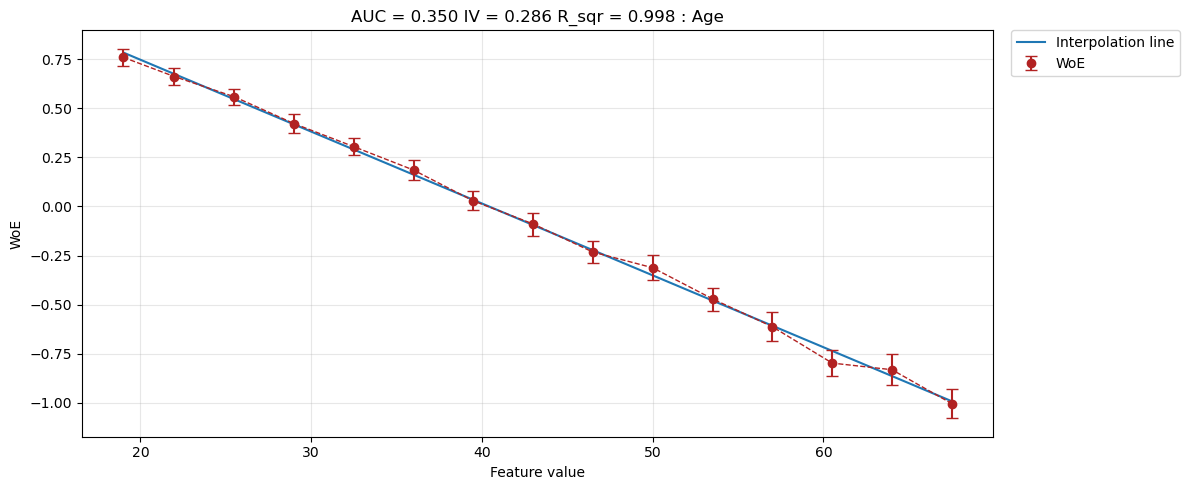

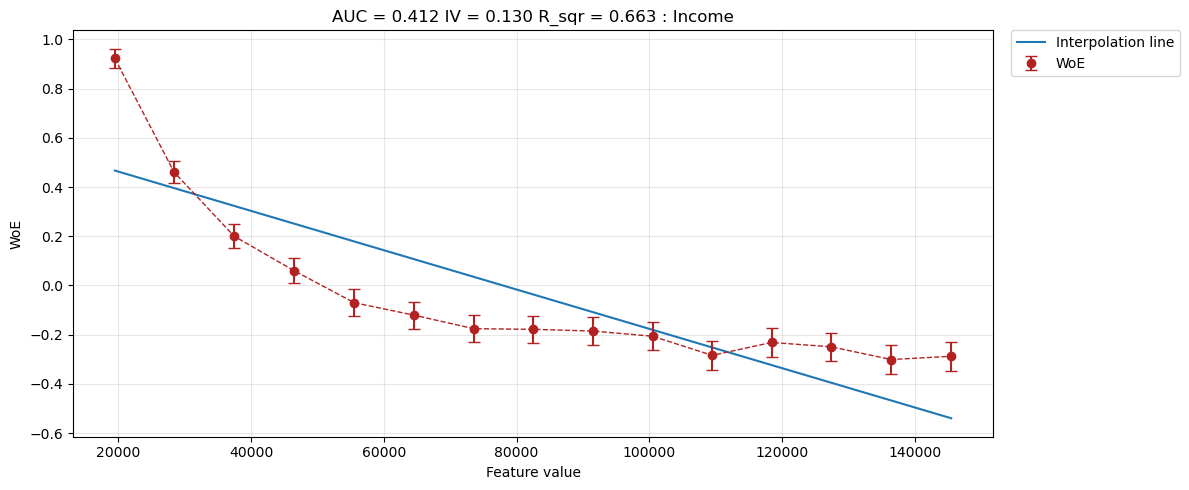

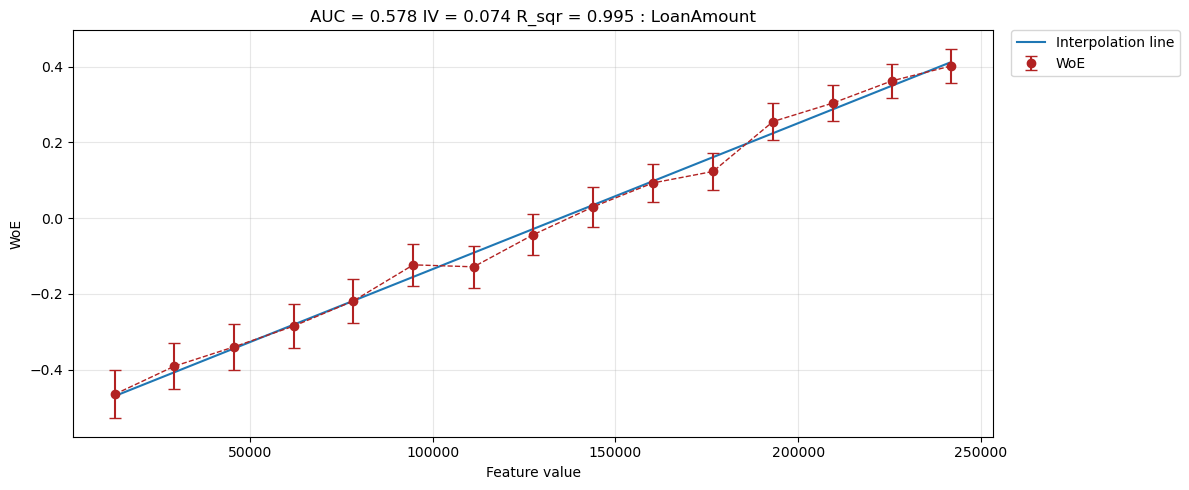

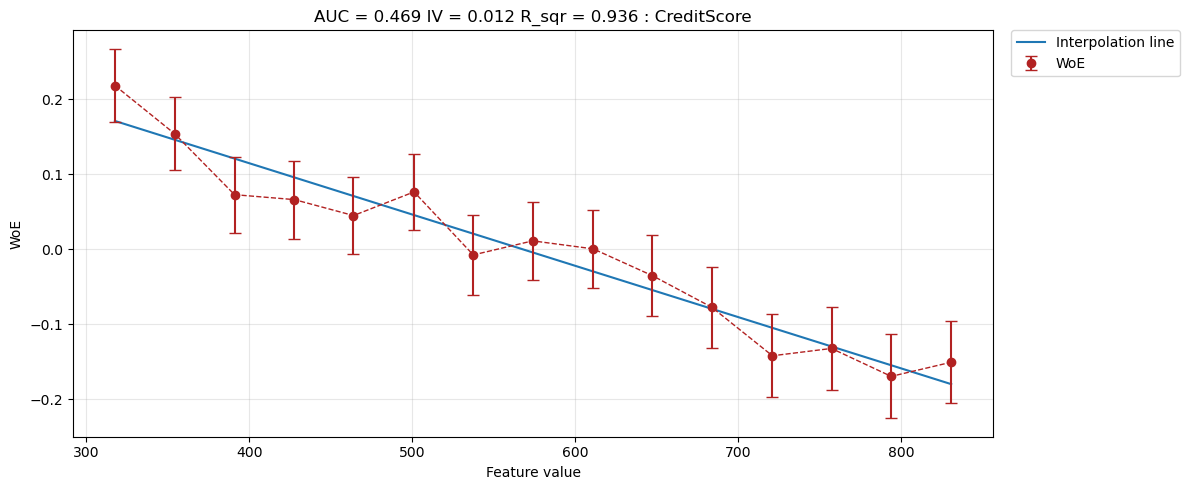

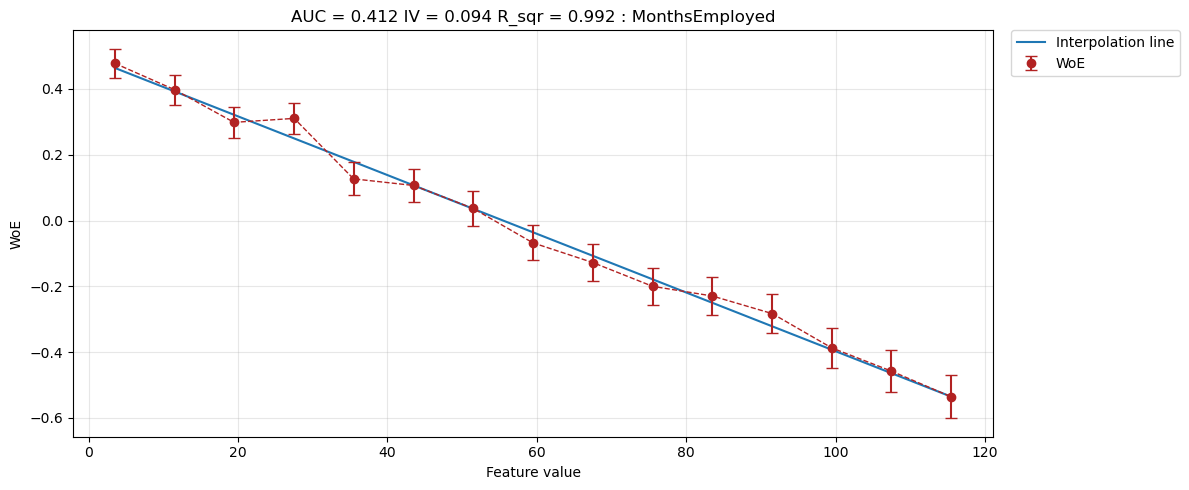

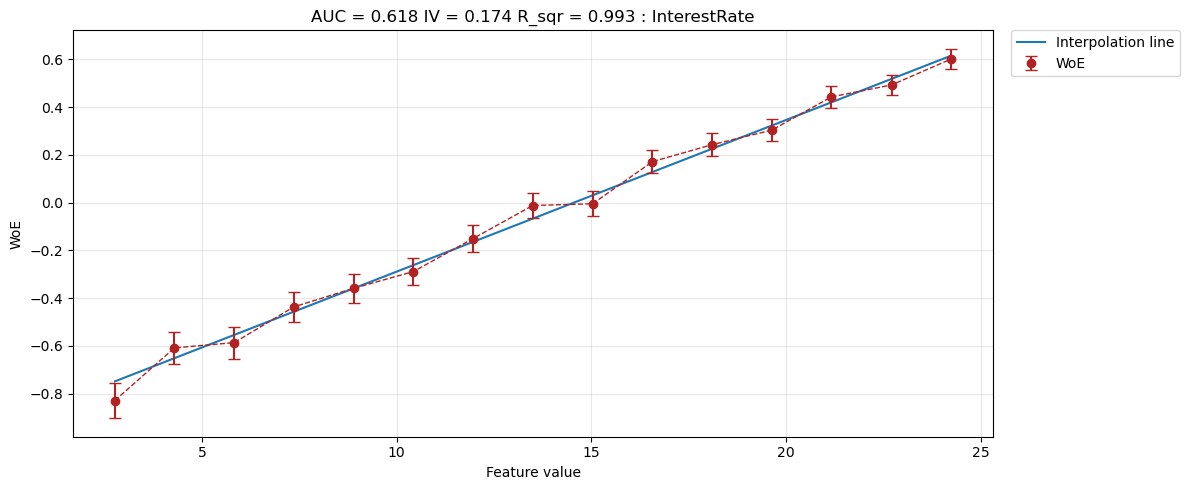

In [19]:
# посмотрим на линейность фичей по woe на 15 бинах

for feature in numeric_features:
    woe_line(X_train[feature], y_train, 15)

Попробуем логарифмировать признак `Income`:

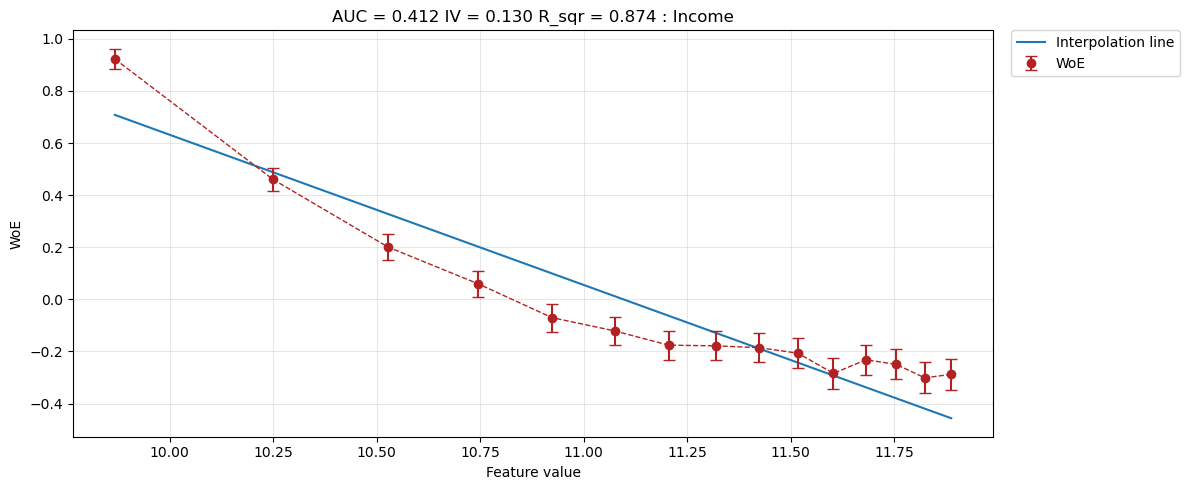

In [20]:
woe_line(np.log(X_train['Income']), y_train, 15)

Метрика **R_sqr** увеличилась на $0.2$. Справа значения находятся "на плато". Их можно клипануть.

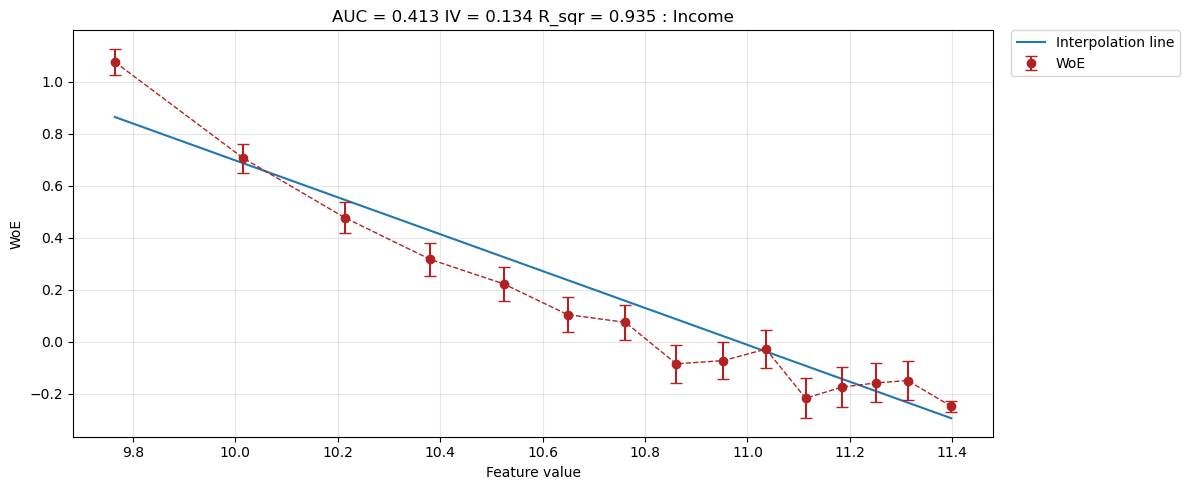

In [21]:
woe_line(np.log(X_train['Income']).clip(upper=11.4), y_train, 15)

Метрика **R_sqr** увеличилась еще на $0.05$. Сохраним значения преобразованного признака:

In [22]:
X_train['Income'] = np.log(X_train['Income']).clip(upper=11.4)
X_test['Income'] = np.log(X_test['Income']).clip(upper=11.4)

У остальных признаков линейность и так хорошая (**R_sqr** $> 0.9$)

## Проверим признаки на мультиколлинеарность

Для этого построим корреляционную матрицу:

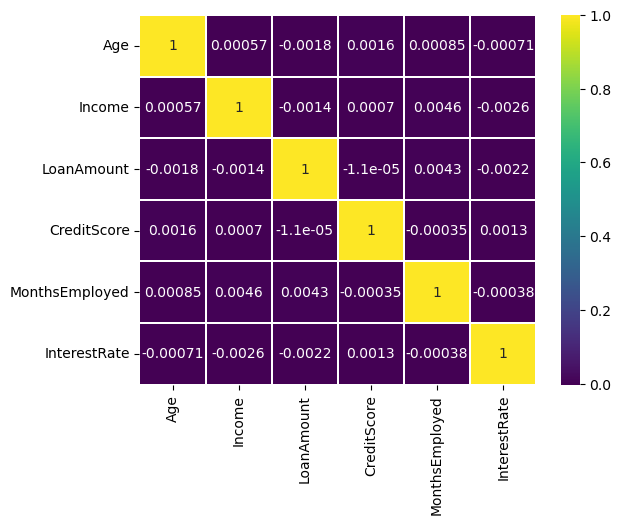

In [23]:
from scipy.stats.stats import pearsonr   
import seaborn as sns

pcorr = pd.DataFrame 
pcorr = []
for f1 in numeric_features:
    for f2 in numeric_features:
        pcorr.append((f1,f2,pearsonr(X_train[f1],X_train[f2])))
        
cor = X_train.loc[:,numeric_features].corr(method='pearson')
cm=plt.cm.viridis
sns.heatmap(cor,cmap=cm,linewidths=0.1,linecolor='white',annot=True)
plt.show()

Все выборочные коэффициенты корреляции маленькие (<0.3), значит мультиколлинеарность не наблюдается.

## Создадим и обучим модель

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from scipy.special import logit
from sklearn.metrics import roc_auc_score

Для начала отскалируем фичи:

In [25]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
logreg = LogisticRegression(penalty=None, random_state=42)
logreg.fit(X_train_scaled, y_train)

# предсказания
train_pred = logreg.predict_proba(X_train_scaled)[:, 1]
test_pred = logreg.predict_proba(X_test_scaled)[:, 1]

logit_logreg_train = logit(train_pred)
logit_logreg_test = logit(test_pred)

# roc auc на трейне и тесте
roc_auc = roc_auc_score(y_test, test_pred)
print('ROC-AUC на трейне: ', round(roc_auc_score(y_train, train_pred), 3), '\n', 'ROC-AUC на тесте: ', round(roc_auc_score(y_test, test_pred), 3), sep='')

ROC-AUC на трейне: 0.751
ROC-AUC на тесте: 0.755


Модель показывает идентичные результаты на обучающей и тестовой выборках, что говорит о **хорошем качестве и отсутствии переобучения.**

Посмотрим на метрики качества модели.

In [27]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, confusion_matrix, classification_report)

y_pred_proba = logreg.predict_proba(X_test_scaled)[:, 1]
y_pred = logreg.predict(X_test_scaled)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")

Accuracy: 0.8862
Precision: 0.6027
Recall: 0.0457
F1-score: 0.0850


Низкие значения `Recall` и `F1-score` указывают на то, что модель практически не обнаруживает дефолтные случаи, хотя общая точность высока из-за сильного дисбаланса классов. Модель нашла только $4.5$% всех реальных дефолтов.   
Добавим в модель параметр `class_weight='balanced'` для увеличения "штрафа" за ошибки по редкому классу (0).

In [28]:
logreg_balanced = LogisticRegression(class_weight='balanced', penalty=None, random_state=42)
logreg_balanced.fit(X_train_scaled, y_train)

# предсказания
train_pred = logreg_balanced.predict_proba(X_train_scaled)[:, 1]
test_pred = logreg_balanced.predict_proba(X_test_scaled)[:, 1]

logit_logreg_train_bal = logit(train_pred)
logit_logreg_test_bal = logit(test_pred)

# roc auc на трейне и тесте
roc_auc = roc_auc_score(y_test, test_pred)
print('ROC-AUC на трейне: ', round(roc_auc_score(y_train, train_pred), 3), '\n', 'ROC-AUC на тесте: ', round(roc_auc_score(y_test, test_pred), 3), sep='')

ROC-AUC на трейне: 0.751
ROC-AUC на тесте: 0.755


In [29]:
y_pred_proba = logreg_balanced.predict_proba(X_test_scaled)[:, 1]
y_pred = logreg_balanced.predict(X_test_scaled)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")

Accuracy: 0.6824
Precision: 0.2222
Recall: 0.6984
F1-score: 0.3371


**Изменения:**  
`Recall` вырос с $0.05$ до $0.68$ (модель теперь находит $68$% дефолтов вместо $5$%).   
`Precision` снизилась с $0.61$ до $0.22$ (только $22$% предсказанных дефолтов действительно являются дефолтами).  
`Accuracy` снизилась с $0.88$ до $0.68$ (меньше точных ответов в целом).  
`F1-score` вырос с $0.08$ до $0.33$ (баланс precision и recall улучшился).  

**Какая модель лучше** — зависит от целей бизнеса.  
  
Если банк хочет минимизировать потери от дефолтов, готов чаще отказывать хорошим клиентам — лучше текущая модель `logreg_balanced` (высокий recall).
Если банк хочет максимизировать выдачу, не хочет отказывать хорошим клиентам, готов мириться с потерями от дефолтов — лучше первоначальная модель `logreg` (высокая точность).

Построим графики линейности по WoE получившейся модели `logreg_balanced` на трейне и тестовой выборке:

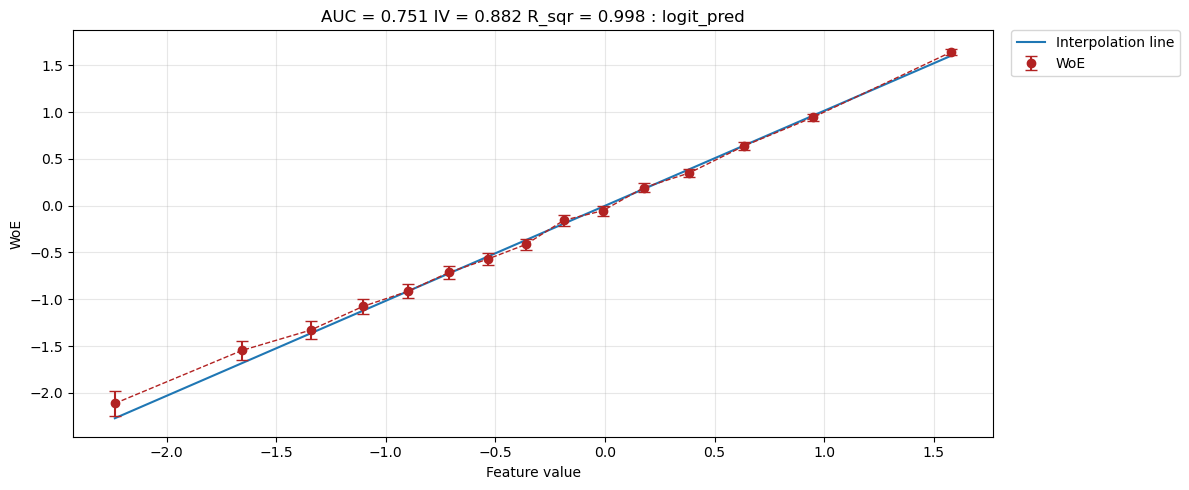

In [30]:
# на трейне
woe_line(
    pd.Series(logit_logreg_train_bal, name='logit_pred').reset_index(drop=True),
    y_train.reset_index(drop=True),
    15
)

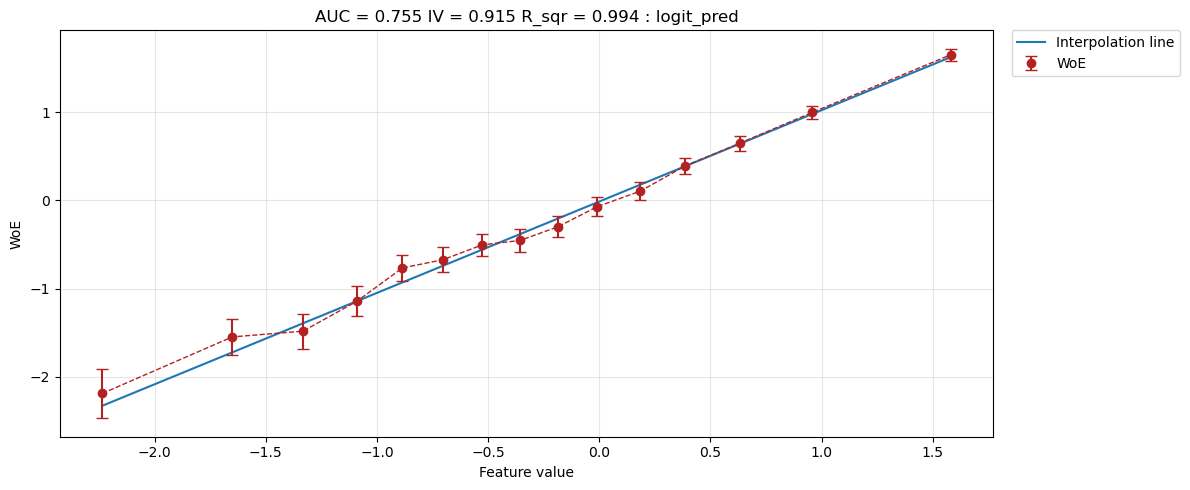

In [31]:
# на тесте
woe_line(
    pd.Series(logit_logreg_test_bal, name='logit_pred').reset_index(drop=True),
    y_test.reset_index(drop=True),
    15
)

## Интерпретация коэффициентов логистической регрессии

Визуализируем важность фичей полученной линейной модели.

Text(0.5, 0, 'Abs Coefficient')

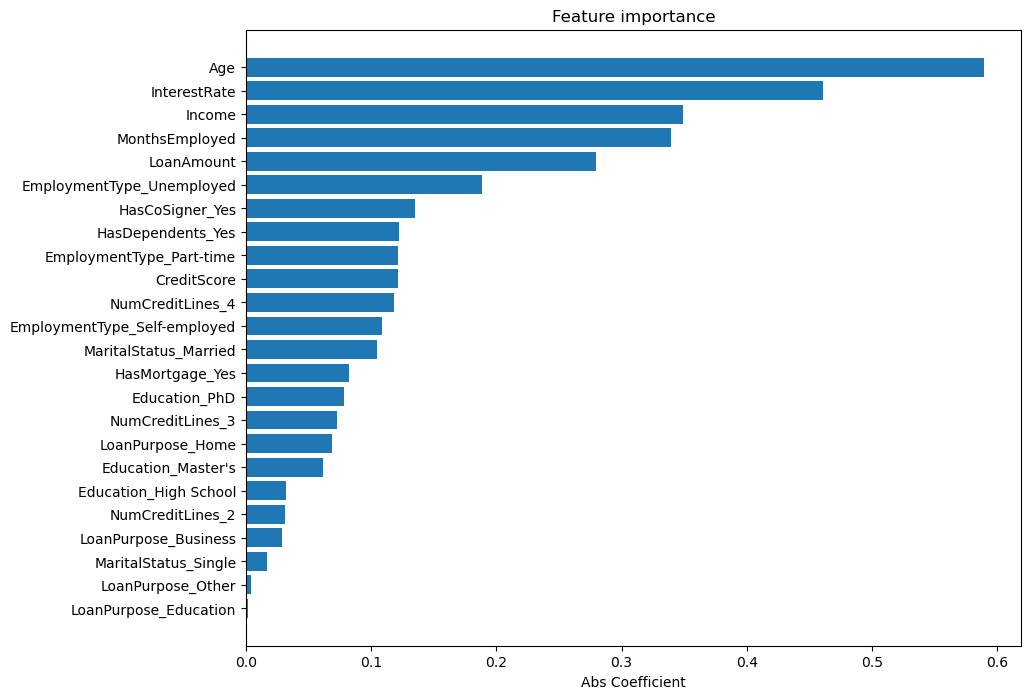

In [32]:
# в логреге важность - это абсолютное значение коэффициентов

importance = pd.DataFrame({
    'feature': features,
    'abs_coef': np.abs(logreg_balanced.coef_[0])
})

importance = importance.sort_values('abs_coef')

plt.figure(figsize=(10, 8))

plt.barh(importance['feature'], importance['abs_coef'])

plt.title('Feature importance')
plt.xlabel('Abs Coefficient')

Проведем интерпретацию коэффициентов обученной логистической регрессии для оценки влияния признаков на вероятность дефолта заемщика.

In [33]:
feature_names = X_train.columns.tolist()

coefficients = pd.DataFrame({
    'feature': feature_names,
    'coefficient': logreg_balanced.coef_[0]
})

coefficients = coefficients.sort_values('coefficient', ascending=False)

print('Коэффициенты логистической регрессии')
print(coefficients)
print(f"\nСвободный член (intercept): {logreg_balanced.intercept_[0]:.4f}")

Коэффициенты логистической регрессии
                         feature  coefficient
5                   InterestRate     0.460552
2                     LoanAmount     0.279588
14     EmploymentType_Unemployed     0.188921
12      EmploymentType_Part-time     0.121742
8               NumCreditLines_4     0.118290
13  EmploymentType_Self-employed     0.108719
7               NumCreditLines_3     0.072432
9          Education_High School     0.031999
6               NumCreditLines_2     0.031317
19          LoanPurpose_Business     0.028547
20         LoanPurpose_Education    -0.001688
22             LoanPurpose_Other    -0.004380
16          MaritalStatus_Single    -0.016682
10            Education_Master's    -0.061802
21              LoanPurpose_Home    -0.068510
11                 Education_PhD    -0.078454
17               HasMortgage_Yes    -0.082275
15         MaritalStatus_Married    -0.104874
3                    CreditScore    -0.121288
18             HasDependents_Yes    -0.1226

**Факторы, увеличивающие вероятность дефолта:**  
Чем выше процентная ставка (`InterestRate`) и/или сумма кредита (`LoanAmount`), тем выше вероятность дефолта.  
Также для безработных (`EmploymentType_Unemployed`) и работающих на неполной занятости (`EmploymentType_Part`) риски выше.  

**Факторы, уменьшающие вероятность дефолта:**  
Чем больше возраст (`Age`), доход (`Income`) и/или трудовой стаж на текущем месте работы (`MonthsEmployed`) заемщика, тем заемщик надежнее.  
Также наличие поручителя (`HasCoSigner_Yes`) и наличие иждивенцев (`HasDependents_Yes`) у заемщика говорит о снижении рисков.